In [1]:
%cd ..
%rm -r lightning_logs/
%pwd

/home/quasar/GitHub/TradeForecast


/home/quasar/GitHub/TradeForecast/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/quasar/GitHub/TradeForecast'

In [2]:
from tradeforecast.augmentation import RNNDataset
from tradeforecast.viz import plot_rnn_forecasts
from tradeforecast.forecast.base import LitBase
from torch.utils.data import DataLoader
from lightning import Trainer
from torch import Tensor
from torch import optim
import torch.nn.functional as F

def predict(model: LitBase, data_loader: DataLoader, dataset: RNNDataset):
    y: Tensor; y_pred: Tensor
    y, y_pred = model.predict(data_loader)
    y = dataset.inverse_transform(y.numpy())
    y_pred = dataset.inverse_transform(y_pred.numpy())
    plot_rnn_forecasts(y, y_pred)
    return

In [3]:
from tradeforecast.augmentation import DataEntryPoint, Indicators, FeatureEngg

data_entry = DataEntryPoint(csv_fpath='AAPL_1d_max_(2010-01-01-2024-12-06).csv')

indicators = Indicators(data_entry)
indicators.add_moving_average().add_moving_average(n=30).add_macd_sl().add_rsi().add_atr()

features = FeatureEngg(data_entry)
features.add_quarters().add_weeks()

lf = data_entry.data.drop_nulls().drop('High','Low')
lf.head().collect()

Datetime,Close,Open,Volume,SMA_close_9,SMA_close_30,MACD_close_12-26,MACD-SL_close_9,RSI_close_14,ATR_close_14,Quarter_sin,Quarter_cos,Week_sin,Week_cos
"datetime[μs, EST]",f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-02-21 19:00:00 EST,7.157857,7.226429,390563600,7.148135,7.225512,-0.020182,-0.043646,50.213892,0.152137,1.0,0.0,0.737833,0.674983
2010-02-22 19:00:00 EST,7.037857,7.142857,575094800,7.151587,7.20775,-0.027162,-0.039953,40.503417,0.158657,1.0,0.0,0.812487,0.582979
2010-02-23 19:00:00 EST,7.166429,7.079643,460566400,7.173572,7.1965,-0.02264,-0.036165,51.982977,0.158358,1.0,0.0,0.812487,0.582979
2010-02-24 19:00:00 EST,7.214286,7.049286,665126000,7.186786,7.18969,-0.015228,-0.031669,55.657482,0.165709,1.0,0.0,0.812487,0.582979
2010-02-25 19:00:00 EST,7.307857,7.227857,507460800,7.203611,7.182512,-0.002156,-0.025423,62.185845,0.158679,1.0,0.0,0.812487,0.582979


In [4]:
from tradeforecast.augmentation import train_val_test_split

dataset_kwargs = {'lf': lf,
                 'non_temporal': [x for x in data_entry.non_temporal if x not in ['High', 'Low']],
                 'temporal': data_entry.temporal,
                 'target': 'Close',
                 'look_back_len': 60,
                 'forecast_len': 5}

rnn_dataset = RNNDataset(**dataset_kwargs)

train_dataset, test_dataset = train_val_test_split(rnn_dataset, test_size=0.1)

batch_size = 128
num_workers = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)

## Train LSTM model

In [5]:
from tradeforecast.forecast import LSTM
from tradeforecast.forecast.utils import OverrideEpochStepCallback

lstm_kwargs = {'input_size': len(rnn_dataset.features),
              'hidden_size': 32,
              'n_LSTM': 2,
              'bidirectional': False,
              'fc_out_size':[],
              'output_size': rnn_dataset.forecast_len,
              'dropout': 0,
              'criterion': F.mse_loss,
              'lr': 0.1,
              'optimizer': optim.SGD}

lstm_model = LSTM(**lstm_kwargs)

lstm_trainer = Trainer(fast_dev_run=False, max_epochs=1000, log_every_n_steps=10, check_val_every_n_epoch=100)

lstm_trainer.fit(lstm_model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/quasar/GitHub/TradeForecast/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 14.5 K | train
1 | fc_linear | Sequential | 165    | train
-------------------------------------------------
14.6 K    Trainable params
0         Non-trainable params
14.6 K    Total params
0.059     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 26/26 [00:00<00:00, 70.32it/s, v_num=0, train/loss=0.00264, step=998.0, lr=0.00313]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 26/26 [00:00<00:00, 69.33it/s, v_num=0, train/loss=0.00264, step=998.0, lr=0.00313]


In [6]:
test_loss = lstm_trainer.test(lstm_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 225.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.15107963979244232
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


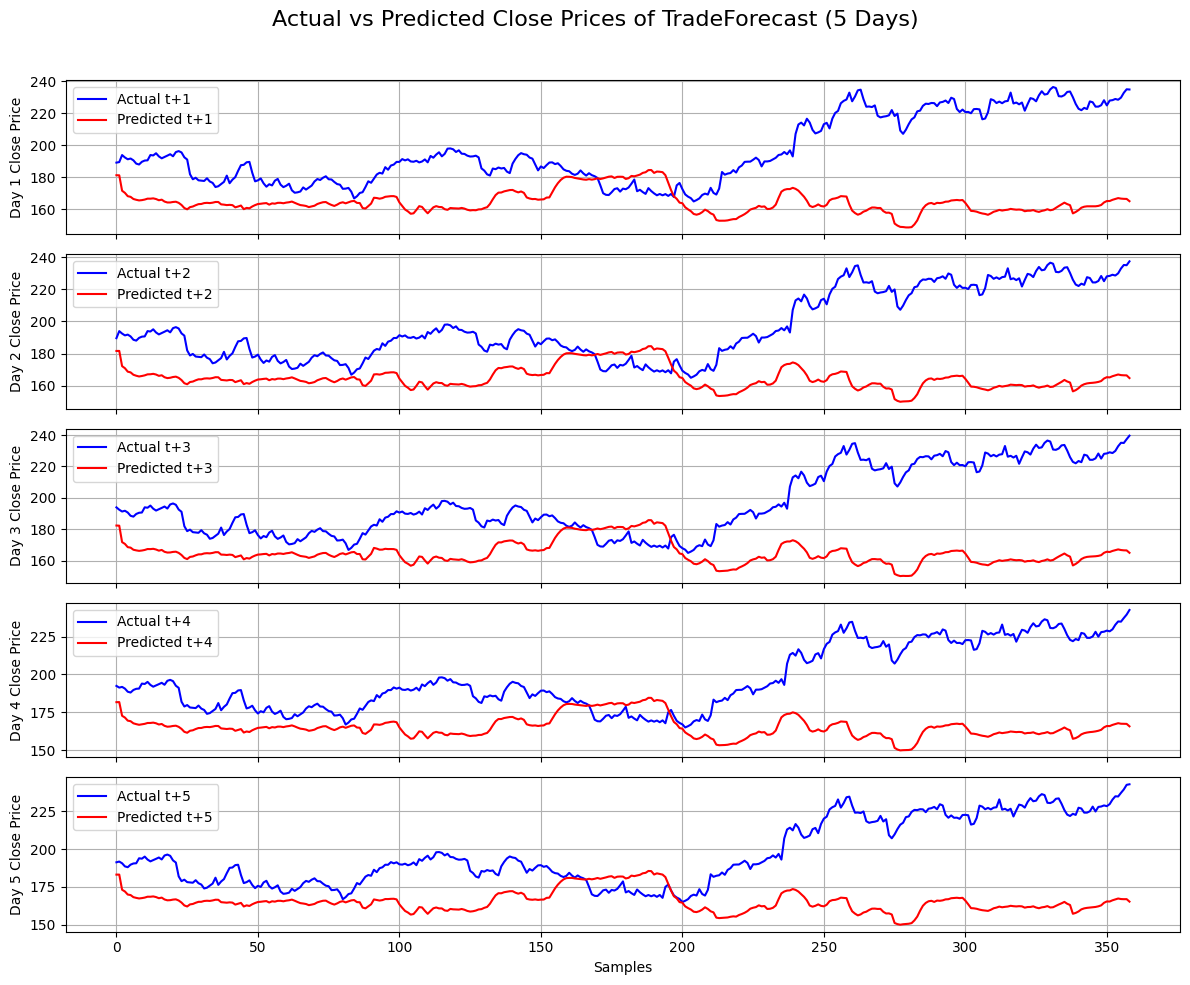

In [7]:
predict(lstm_model, test_loader, rnn_dataset)

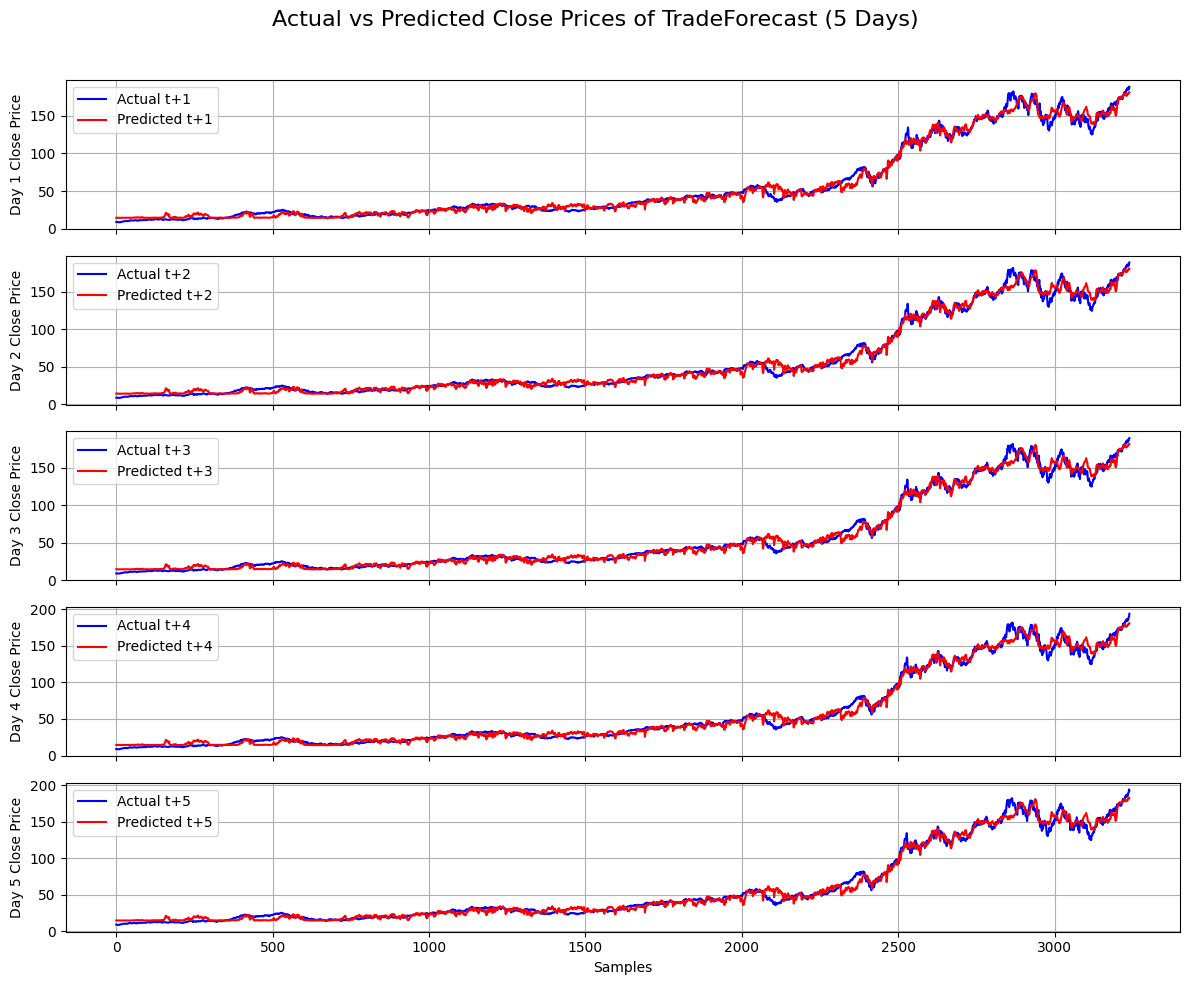

In [14]:
predict(lstm_model, train_loader, rnn_dataset)

In [8]:
model_fname = lstm_model.save_model_state(ticker_interval='AAPL_1d')
model_fname

'AAPL_1d_LSTM_14629_5.pth'

## Train TF model

In [9]:
from tradeforecast.forecast import TFModel

tf_kwargs = {'input_size': len(rnn_dataset.features),
            'conv_out_size': len(rnn_dataset.features)*2,
            'kernel_size': rnn_dataset.forecast_len,
            'hidden_size': 32,
            'n_LSTM': 2,
            'bidirectional': False,
            'fc_out_size':[],
            'output_size': rnn_dataset.forecast_len,
            'dropout': 0,
            'criterion': F.mse_loss,
            'lr': 0.1,
            'optimizer': optim.SGD}

tf_model = TFModel(**tf_kwargs)

tf_trainer = Trainer(fast_dev_run=False, max_epochs=1000, log_every_n_steps=10, check_val_every_n_epoch=100)

tf_trainer.fit(tf_model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/quasar/GitHub/TradeForecast/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | conv1d    | Conv1d      | 1.7 K  | train
1 | bnorm     | BatchNorm1d | 52     | train
2 | avg_pool  | AvgPool1d   | 0      | train
3 | lstm      | LSTM        | 16.1 K | train
4 | fc_linear | Sequential  | 165    | train
--------------------------------------------------
18.1 K    Trainable params
0         Non-trainable params
18.1 K    Total params
0.072     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 26/26 [00:00<00:00, 65.01it/s, v_num=1, train/loss=0.000956, step=998.0, lr=0.00156]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 26/26 [00:00<00:00, 63.99it/s, v_num=1, train/loss=0.000956, step=998.0, lr=0.00156]


In [10]:
tf_trainer.test(tf_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 178.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.5298201441764832
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.5298201441764832}]

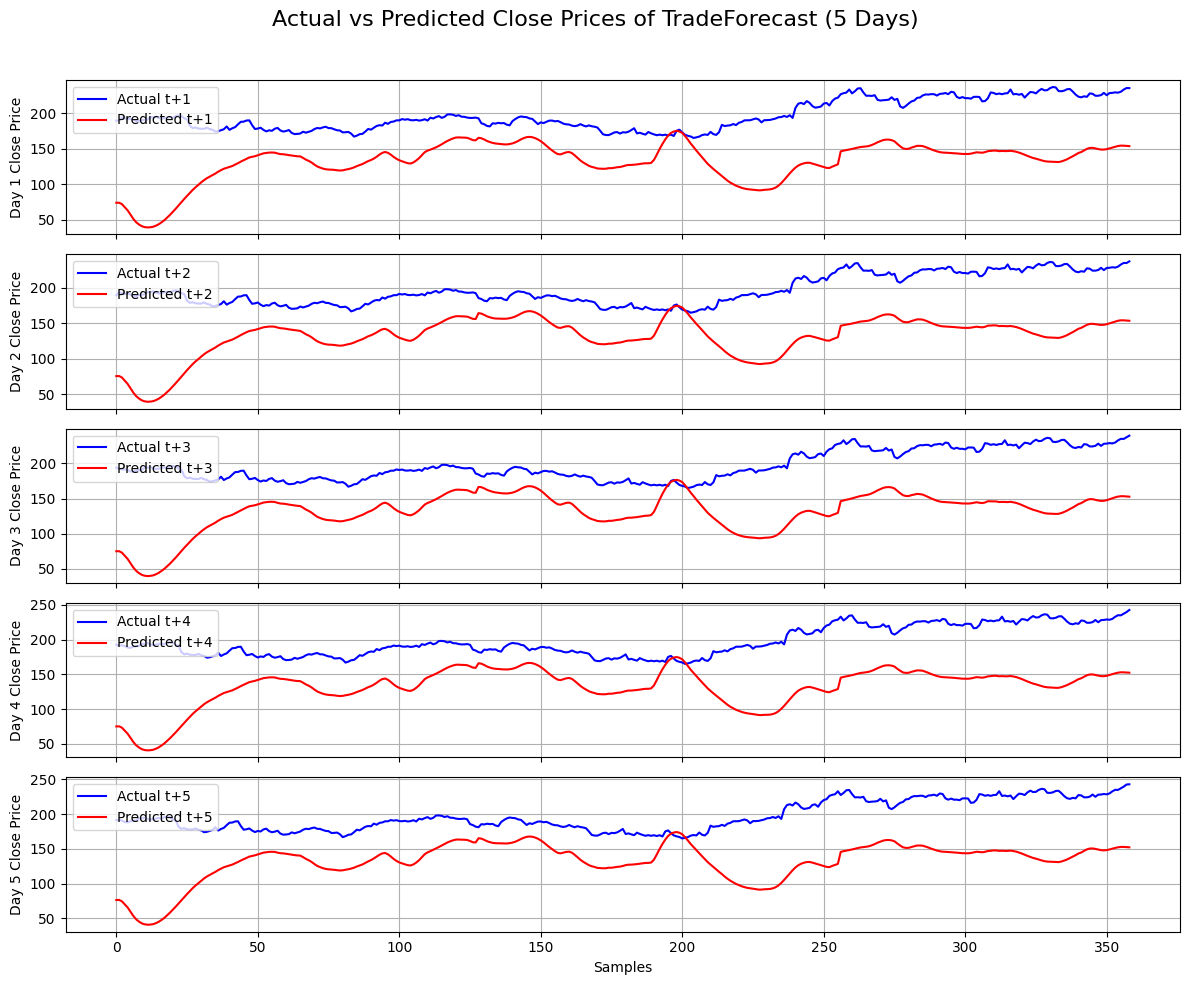

In [11]:
predict(tf_model, test_loader, rnn_dataset)

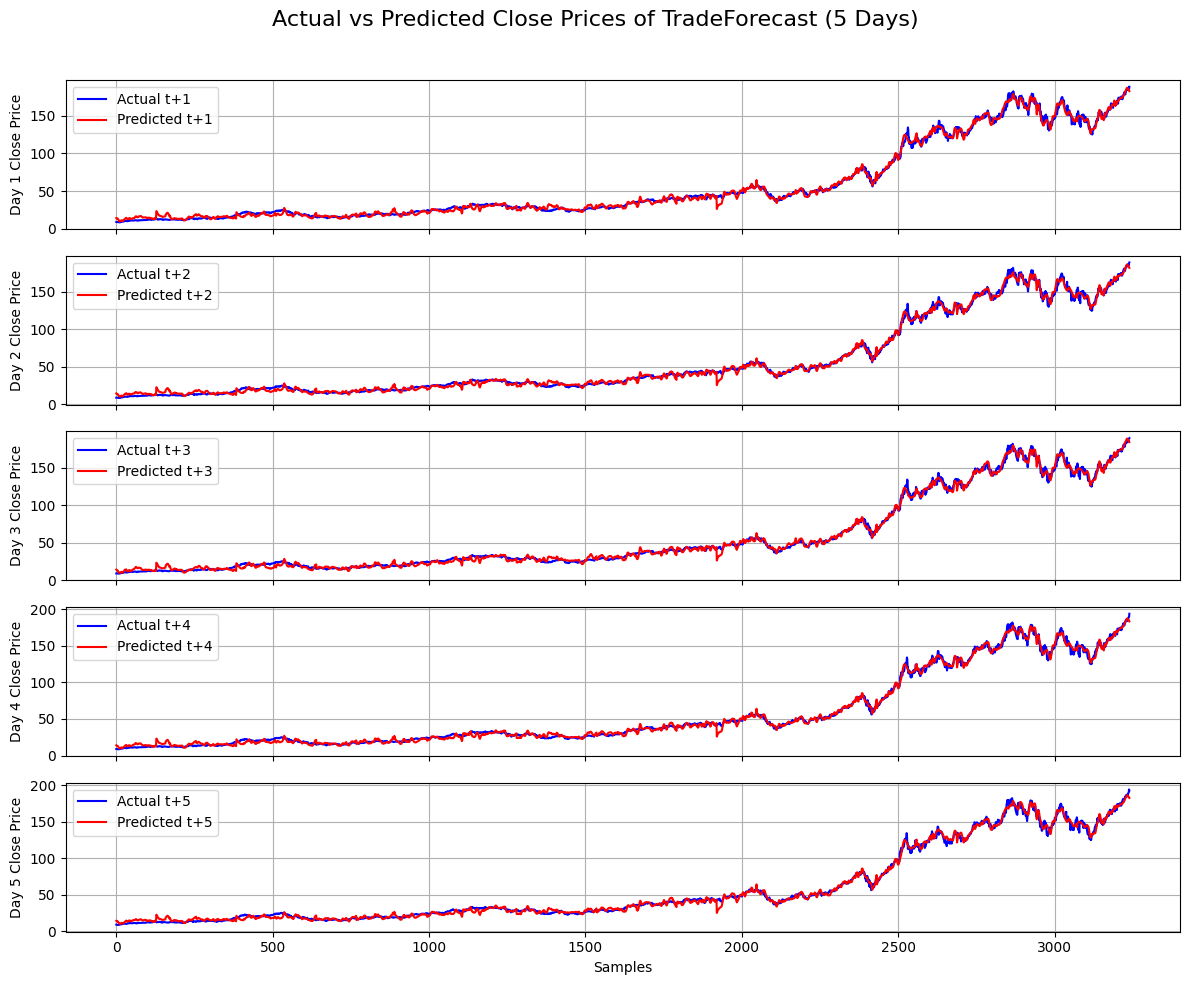

In [15]:
predict(tf_model, train_loader, rnn_dataset)

In [12]:
model_fname = tf_model.save_model_state(ticker_interval='AAPL_1d')
model_fname

'AAPL_1d_TFModel_18061_5.pth'

## Train TFTransformer Model

In [5]:
from tradeforecast.forecast import TFTransformer

tft_kwargs = {'input_size': len(rnn_dataset.features),
            'nhead': 4,
            'd_model': 64,
            'num_layers': 4,
            'output_size': rnn_dataset.forecast_len,
            'dropout': 0,
            'criterion': F.l1_loss,
            'lr': 0.05,
            'optimizer': optim.SGD}

tft_model = TFTransformer(**tft_kwargs)

tft_trainer = Trainer(fast_dev_run=False, max_epochs=1000, log_every_n_steps=10, check_val_every_n_epoch=100)

tft_trainer.fit(tft_model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/quasar/GitHub/TradeForecast/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | input_layer         | Linear             | 896    | train
1 | positional_encoding | PositionalEncoding | 0      | train
2 | encoder             | TransformerEncoder | 1.1 M  | train
3 | output_layer        | Linear             | 325    | train
-------------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.503     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval 

Epoch 999: 100%|██████████| 26/26 [00:01<00:00, 20.66it/s, v_num=0, train/loss=0.0207, step=998.0, lr=0.000781]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 26/26 [00:01<00:00, 19.25it/s, v_num=0, train/loss=0.0207, step=998.0, lr=0.000781]


In [6]:
tft_trainer.test(tft_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 50.86it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.31712380051612854
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.31712380051612854}]

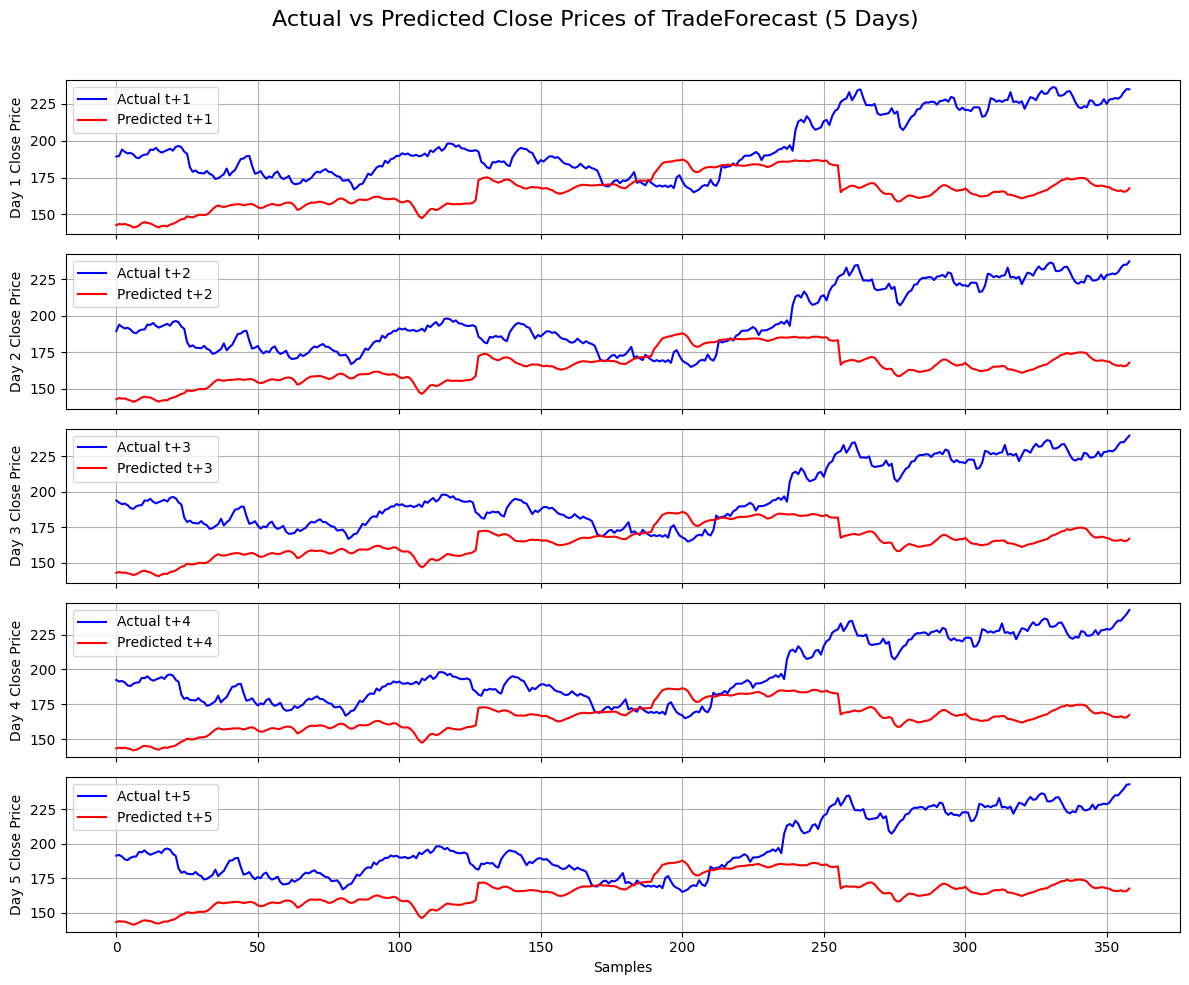

In [7]:
predict(tft_model, test_loader, rnn_dataset)

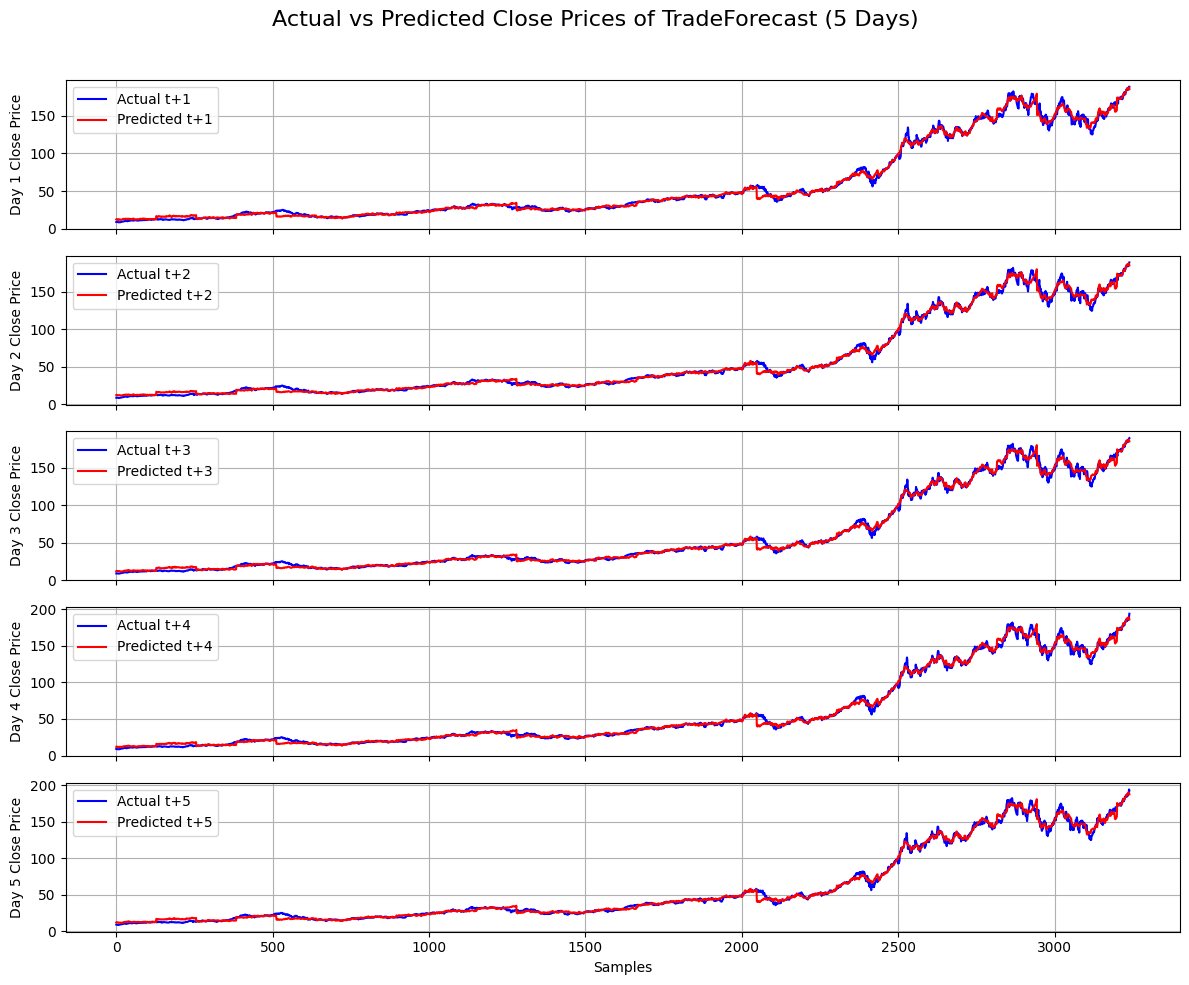

In [8]:
predict(tft_model, train_loader, rnn_dataset)

In [9]:
model_fname = tft_model.save_model_state(ticker_interval='AAPL_1d')
model_fname

'AAPL_1d_TFTransformer_1125829_5.pth'